In [104]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [157]:
df = pd.read_csv('../data/at-dataset/final_data.csv')
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)

In [ ]:
df.head(5)
# print(df.info())

NameError: name 'df' is not defined

In [158]:
def showFigureEachLaneTraffic(df):
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)
    print(num_lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

def showFigureEachLaneTrafficForOneWeek(df):
    df = df[(df.index > '2024-10-01') & (df.index <= '2024-10-07')]
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)
    print(num_lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

In [159]:
# sub_df = df[(df['Detector_ID'] == 2013) & (df['Lane'] == 1)]
sub_df = df
# & (df.index > '2024-10-01') & (df.index < '2024-12-01')
# sub_df['Volume'].plot(style='.', figsize=(20, 5), title='Traffic Volume over Time', xlabel='DateTime', ylabel='Traffic Volume')
# showFigureEachLaneTrafficForOneWeek(sub_df)

In [160]:
train = sub_df.loc[sub_df.index < '2024-10-01']
test = sub_df.loc[sub_df.index >= '2024-10-01']
# fig, ax = plt.subplots(figsize=(20, 5))
# train['Volume'].plot(ax=ax, label='Training Data')
# test['Volume'].plot(ax=ax, label='Testing Data')
# plt.axvline('2024-10-01', color='black', linestyle='--', label='Train-Test Split')
# plt.legend()
# plt.show()

In [161]:
## Feature Creation
def create_time_features(df):
    df = df.copy().sort_index()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

    # # cyclical encodings
    # df["sin_hour"] = np.sin(2*np.pi*df["hour"]/24)
    # df["cos_hour"] = np.cos(2*np.pi*df["hour"]/24)
    # df["sin_dow"]  = np.sin(2*np.pi*df["dayofweek"]/7)
    # df["cos_dow"]  = np.cos(2*np.pi*df["dayofweek"]/7)

    # # ---- LAGS (hourly)
    # # short-term: 1–12h, daily pattern: 24–25h, multi-day & weekly: 48–168h
    # lags = [1, 2, 3, 6, 12, 24, 25, 48, 72, 168]
    # for L in lags:
    #     df[f"lag_{L}"] = df['Volume'].shift(L)

    # # ---- ROLLING STATS (use shift(1) to avoid leakage)
    # # 3h, 6h, 12h, 24h (1d), 168h (1w)
    # wins = {"3h":3, "6h":6, "12h":12, "1d":24, "1w":168}
    # for name, w in wins.items():
    #     past = df['Volume'].shift(1)
    #     df[f"roll_mean_{name}"] = past.rolling(w).mean()
    #     df[f"roll_max_{name}"]  = past.rolling(w).max()
    #     df[f"roll_std_{name}"]  = past.rolling(w).std()

    return df

In [162]:
sub_df = create_time_features(sub_df)

In [163]:
train = create_time_features(train)
test  = create_time_features(test)
train = train.dropna()
FEATURES = [
    "Detector_ID","Lane","hour","day","dayofweek","month","year","is_weekend",
    # "sin_hour","cos_hour","sin_dow","cos_dow",
    # "lag_1","lag_2","lag_3","lag_6","lag_12","lag_24","lag_25","lag_48","lag_72","lag_168",
    # "roll_mean_3h","roll_mean_6h","roll_mean_12h","roll_mean_1d","roll_mean_1w",
    # "roll_max_3h","roll_std_3h"
]
TARGET = 'Volume'

In [164]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(n_estimators=2000, early_stopping_rounds=50, learning_rate = 0.1, max_depth = 6, subsample = 0.8, colsample_bytree = 0.8)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=100)
reg.save_model('../models/xgb-model.json')

In [165]:
reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",            # or "gpu_hist"
    max_depth=8,
    learning_rate=0.05,
    n_estimators=3000,             # high cap; early stopping trims it
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.2,
    reg_alpha=0.0,
    reg_lambda=2.0,
    random_state=42,
    early_stopping_rounds=50,
    # enable_categorical=True,     # uncomment if you cast IDs to category & have new XGB
)

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    # eval_metric="rmse",
    verbose=100
)
reg.save_model('../models/xgb-model-v1.json')

[0]	validation_0-rmse:96.78121	validation_1-rmse:100.73666
[100]	validation_0-rmse:65.12442	validation_1-rmse:72.25266
[200]	validation_0-rmse:57.42253	validation_1-rmse:67.20632
[300]	validation_0-rmse:51.25773	validation_1-rmse:63.22405
[400]	validation_0-rmse:47.50991	validation_1-rmse:61.51845
[500]	validation_0-rmse:45.15487	validation_1-rmse:60.42442
[600]	validation_0-rmse:43.44322	validation_1-rmse:59.91970
[700]	validation_0-rmse:41.85752	validation_1-rmse:59.44935
[800]	validation_0-rmse:40.67667	validation_1-rmse:59.09686
[900]	validation_0-rmse:39.58934	validation_1-rmse:58.86704
[1000]	validation_0-rmse:38.75979	validation_1-rmse:58.69011
[1100]	validation_0-rmse:38.14390	validation_1-rmse:58.63749
[1143]	validation_0-rmse:37.89309	validation_1-rmse:58.63118


In [166]:
# reg = xgb.XGBRegressor().load_model('../models/xgb-model.json')
pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_).sort_values(by=0, ascending=False)

,0
Detector_ID,0.309392
Lane,0.241297
hour,0.211621
year,0.064743
is_weekend,0.062419
dayofweek,0.048515
month,0.044832
day,0.017179


In [167]:
test['prediction'] =reg.predict(X_test)

In [168]:
trydf = sub_df.merge(test[['Detector_ID','Lane', 'prediction']], how='left', left_on=['Detector_ID','Lane', sub_df.index], right_on=['Detector_ID','Lane', test.index])
trydf.set_index('key_2', inplace=True)
trydf.index.name = 'DateTime'

In [169]:
def showTrafficVolumeWithPredictions(df, detector_id, lane):
    df = df[(df.index > '2025-07-01') & (df.index <= '2025-07-08') & (df['Lane'] == lane) & (df['Detector_ID'] == detector_id)] 
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.plot(sub_df.index, sub_df['prediction'], '-', label=f'Predictions Lane {lane}')
        ax.set_title(f'Site {detector_id} - Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

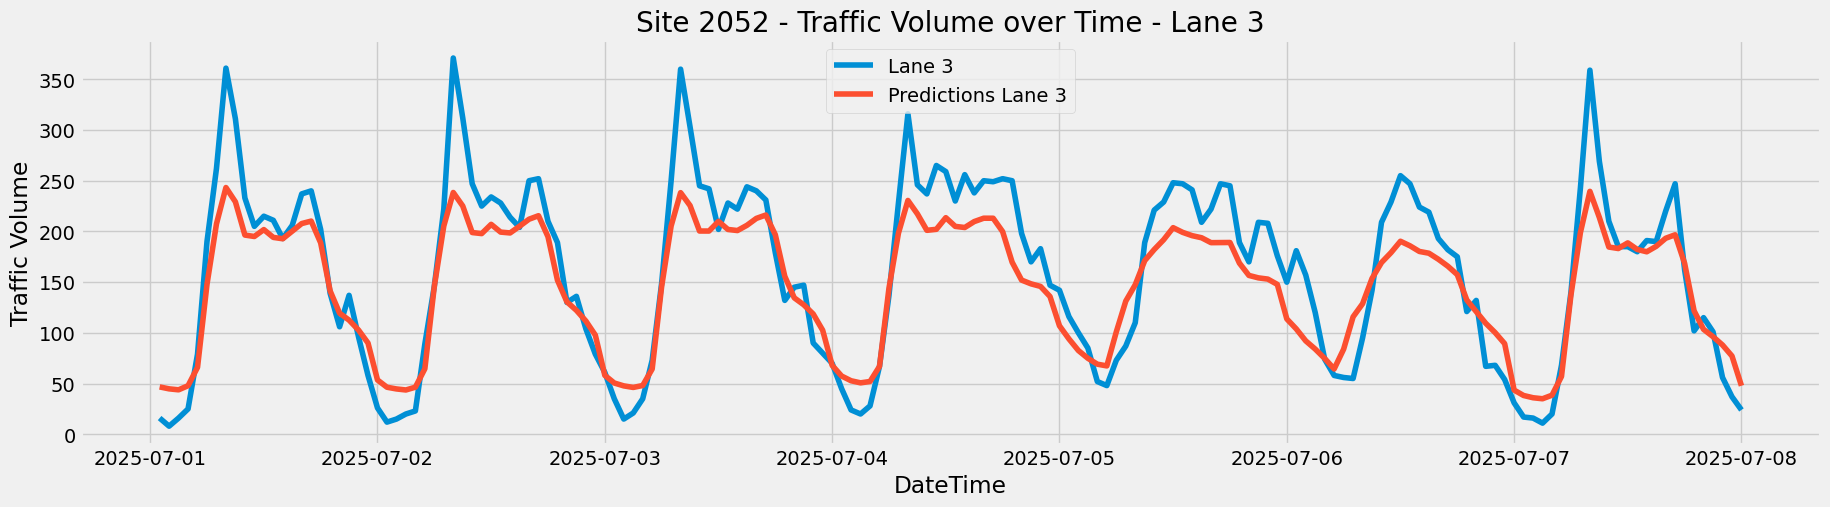

In [171]:
showTrafficVolumeWithPredictions(trydf,2052,3)

In [172]:
average_traffic = pd.DataFrame()
average_traffic['average_volume'] = trydf.groupby(trydf.index).mean()['Volume']
average_traffic['average_prediction'] =trydf.groupby(trydf.index).mean()['prediction']

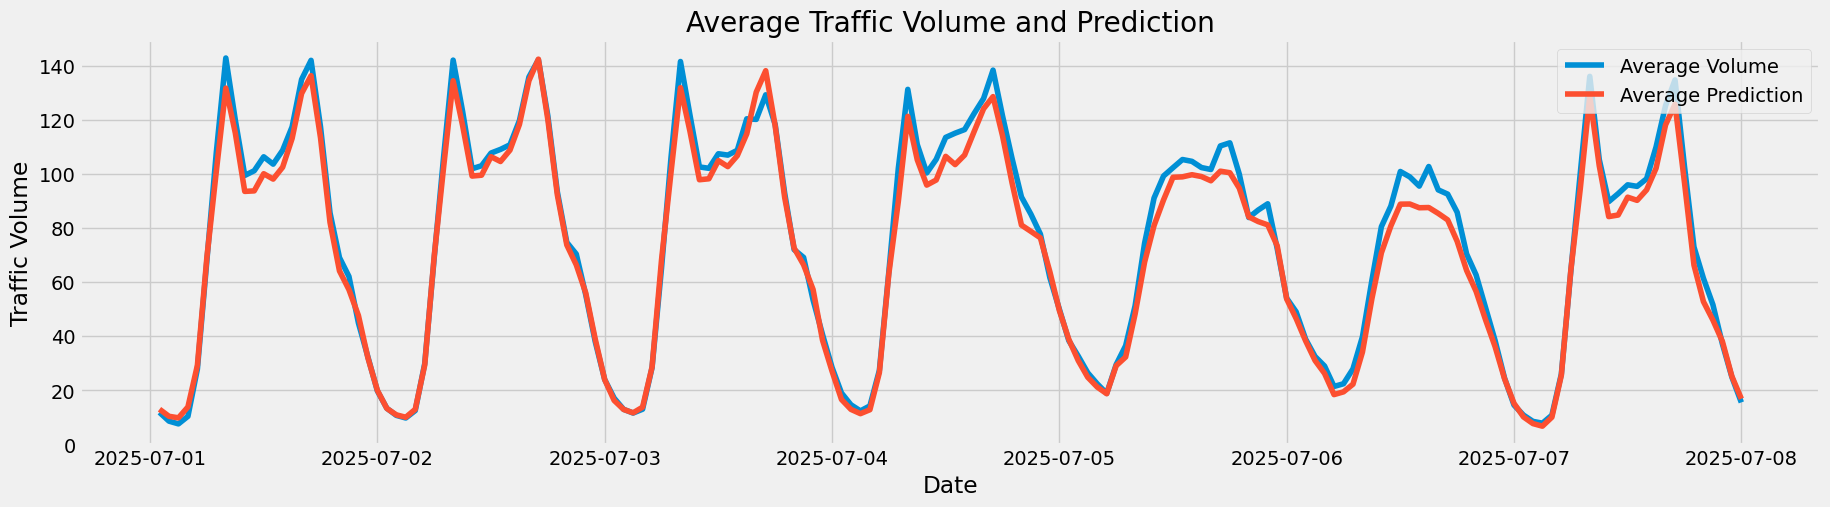

In [173]:
temp = average_traffic[(average_traffic.index > '2025-07-01') & (average_traffic.index <= '2025-07-08')] 
plt.figure(figsize=(20, 5))
plt.plot(temp.index, temp['average_volume'], label='Average Volume')
plt.plot(temp.index, temp['average_prediction'], label='Average Prediction')
plt.title('Average Traffic Volume and Prediction')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()

In [174]:
import shap
import tqdm as notebook_tqdm

In [175]:
background = X_train.sample(min(1000, len(X_train)), random_state=42)

explainer = shap.TreeExplainer(reg, feature_perturbation="tree_path_dependent")

In [176]:
# choose a set to explain
X_explain = X_test  # or X_test

# for speed on big sets, sample
X_explain_sample = X_explain.sample(min(5000, len(X_explain)), random_state=42)

# SHAP values: returns array (n_samples, n_features)
shap_values = explainer.shap_values(X_explain_sample)
# Expected value (model base value)
base_value = explainer.expected_value


In [177]:
print("Base value:", explainer.expected_value)

Base value: 76.73585


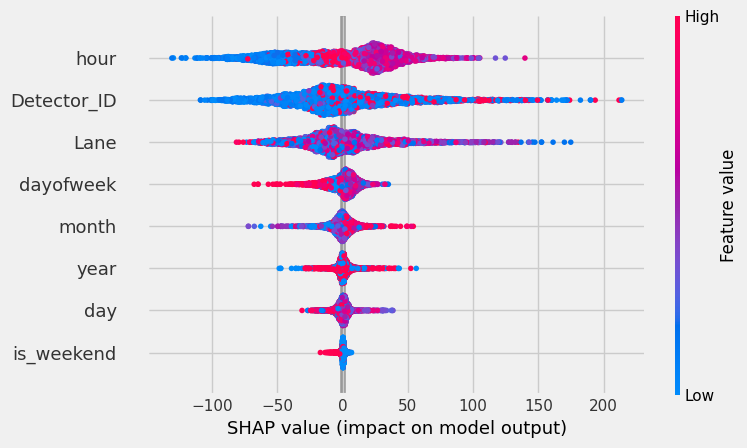

In [179]:
shap.summary_plot(shap_values, X_explain_sample, show=True)

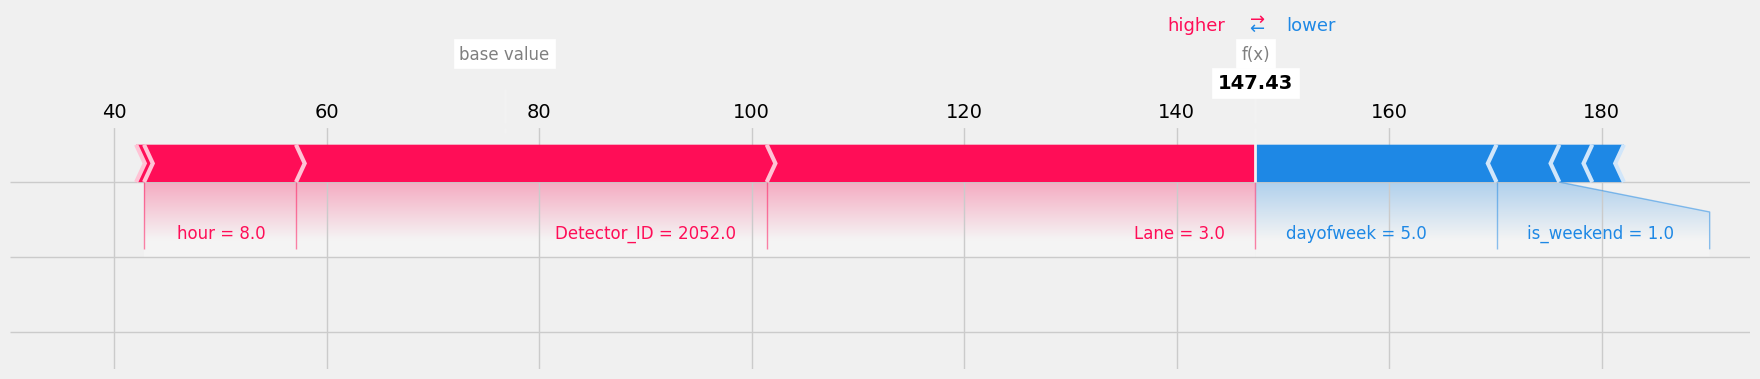

In [184]:
row = X_explain[(X_explain['Lane'] == 3) & (X_explain.index == '2025-07-05 08:00:00') & (X_explain['Detector_ID'] == 2052)]  # replace with your specific row selection

# row = row[selected_features]

sv_row = explainer.shap_values(row)
shap.force_plot(base_value, sv_row, row, matplotlib=True)  # inline plot
plt.show()

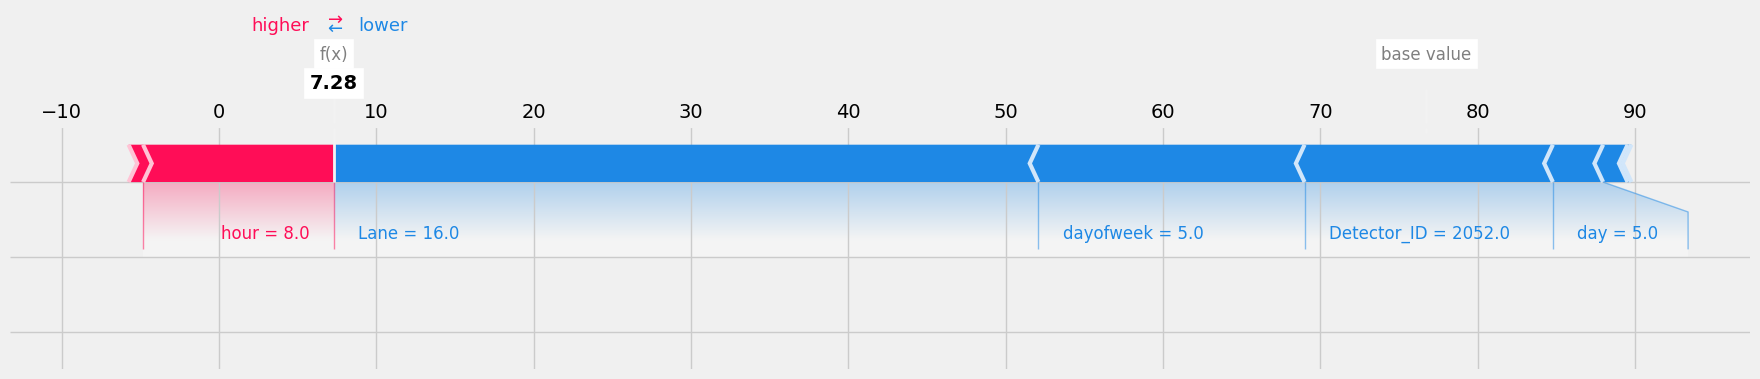

In [186]:
row = X_explain[(X_explain['Lane'] == 16) & (X_explain.index == '2025-07-05 08:00:00') & (X_explain['Detector_ID'] == 2052)]  # replace with your specific row selection

sv_row = explainer.shap_values(row)
shap.force_plot(base_value, sv_row, row, matplotlib=True)  # inline plot
plt.show()

In [181]:
test[(test['Lane'] == 3) & (test.index == '2025-07-05 08:00:00') & (test['Detector_ID'] == 2052)]

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year,is_weekend,prediction
DateTime,,,,,,,,,,
2025-07-05 08:00:00,2052,3,110,8,5,5,7,2025,1,147.425629


In [187]:
test[(test['Lane'] == 16) & (test.index == '2025-07-05 08:00:00') & (test['Detector_ID'] == 2052)]

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year,is_weekend,prediction
DateTime,,,,,,,,,,
2025-07-05 08:00:00,2052,16,8,8,5,5,7,2025,1,7.284603
